In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import math

mpl.style.use('seaborn')
plt.rcParams['figure.figsize'] = [20, 7]

In [2]:
import datetime
from dateutil.parser import parse as parse_date

In [3]:
confirmed = pd.read_csv('CSSEGISandData/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv')
deaths = pd.read_csv('CSSEGISandData/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv')
recovered = pd.read_csv('CSSEGISandData/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv')

In [4]:
pop = dict(pd.read_csv('massaged_pop.csv').set_index('country')['2018'])

In [5]:
T=9 # Time to death
CFR=0.01 # Case Fatality Ratio

# Current date

In [6]:
firstday = parse_date(confirmed.columns[4])
today = parse_date(confirmed.columns[-1])
print('Today: ', today)
numdays = (today - firstday).days+1
print('NumDays: ', numdays)

Today:  2020-03-21 00:00:00
NumDays:  60


In [7]:
def changeColumns(df):
    df.drop(['Lat', 'Long'], axis=1, inplace=True)
    df.rename({'Province/State': 'province', 'Country/Region': 'country'}, axis=1, inplace=True)
changeColumns(confirmed)
changeColumns(deaths)
changeColumns(recovered)

In [8]:
confirmed[~confirmed['province'].isnull()].country.value_counts()

US                247
China              33
Canada             12
France              9
Australia           9
United Kingdom      7
Netherlands         4
Denmark             3
Cruise Ship         1
Name: country, dtype: int64

In [9]:
def sumProvinces(df):
    df = df.copy()
    
    # remove country which has the DiamondPrincess
    df = df[~df.country.str.contains('Others')]
    
    # Sum all provinces for all countries
    # df_no_uc = df[~((df.country == 'China') |  (df.country == 'US'))]
    # df_no_uc = df.copy()
    df_united = df.groupby('country').sum()
    
    idx_list = df_united.index.tolist()
    pos = idx_list.index('China')
    idx_list[pos] = 'China/Total'
    pos = idx_list.index('US')
    idx_list[pos] = 'US/Total'
    df_united.index = idx_list
    
    df_united.index.rename('place', inplace=True)

    df_uc = df[((df.country == 'China') |  (df.country == 'US'))]
    df_uc = df_uc[~df_uc.province.str.contains('Diamond Princess')]
    df_uc['place'] = df_uc['country'] + '/' + df_uc.province.apply(lambda x: x.split(', ')[-1])
    df_uc.drop(['province', 'country'], axis=1, inplace=True)
    # We need to sum because US provinces repeat
    df_uc_sum = df_uc.groupby('place').sum()
    # df_uc.set_index('place', inplace=True)
    
    ret = pd.concat([df_united, df_uc_sum])
    ret.columns = [parse_date(x) for x in ret.columns]
    return ret
con = sumProvinces(confirmed)
rec = sumProvinces(recovered)
dea = sumProvinces(deaths)

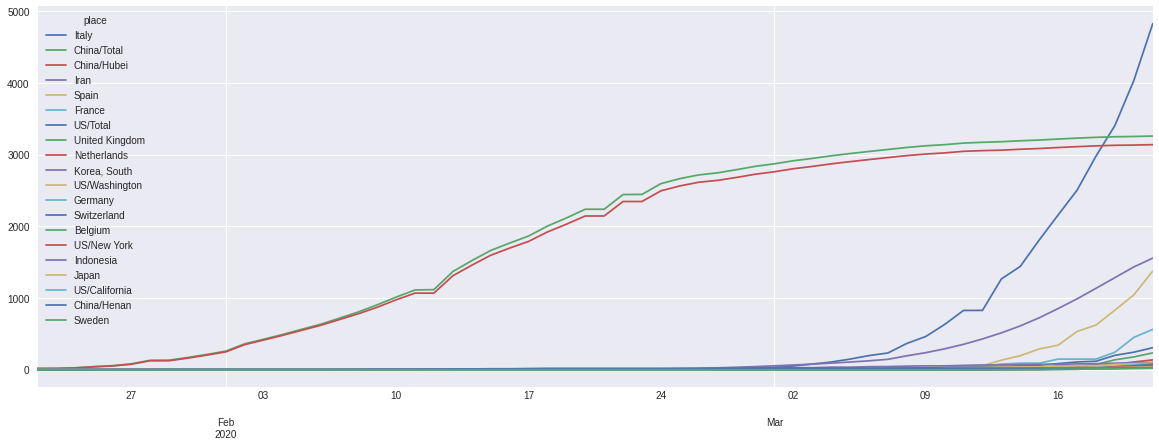

In [10]:
dea.sort_values(today, ascending=False).head(20).T.plot()

In [11]:
def plot3(country, days=numdays, logy=False):
    fig, ax = plt.subplots()
    ax.plot(con[con.index.str.contains(country)][con.columns[-days:]].T, color='blue', label='Confirmed')
    ax.plot((dea[dea.index.str.contains(country)][con.columns[-days:]]).T, color='red', label='Dead')
    ax.plot((rec[rec.index.str.contains(country)][con.columns[-days:]]).T, color='green', label='recovered')
    if logy:
        ax.semilogy()
    ax.legend()

In [12]:
def smoothDaily(series):
    diff = series - series.shift(1)
    return diff.rolling(window=7, win_type='gaussian', center=True).mean(std=0.5)


In [13]:
def last7Growth(s):
    week_growth = (s / s.shift(7))[-7:].mean()
    day_growth = week_growth ** (1/7.)
    print("Weekly growth:", week_growth)
    print("Daily growth:", day_growth)
    return day_growth

def backGuess(country, t=T, cfr=CFR, growth = None):
    df = pd.DataFrame({'confirmed': con.loc[country], 'backguess': (1/cfr)*dea.loc[country].shift(-t)})
    tdaysago = df[:-T]
    lastRatio = df.backguess[-T-1] / df.confirmed[-T-1]
    print("T days ago confirmed_cases=", df.confirmed[-T-1], "backguess=", df.backguess[-T-1], "ratio=", df.backguess[-T-1] / df.confirmed[-T-1])
    lastGuess = df.backguess[-T-1]
    print("Last guess T days ago:", lastGuess)
    if growth == None:
        growth = last7Growth(con.loc[country])
    print("Extrapolating with growht factor:", growth)
    for i in range(T):
        lastGuess *= growth
        df.loc[df.index[-T+i], 'backguess'] = lastGuess

    print("Extrapolating to today from with growth factor:", df.backguess[-1])

    print("Reported confirmed today: ", df.confirmed[-1])
    print("Extrapolating from today confirmed by last ratio seen: ", df.confirmed[-1] * lastRatio)

    return df


In [14]:
country = 'US/Total'

## Confirmed, Recovered, Death

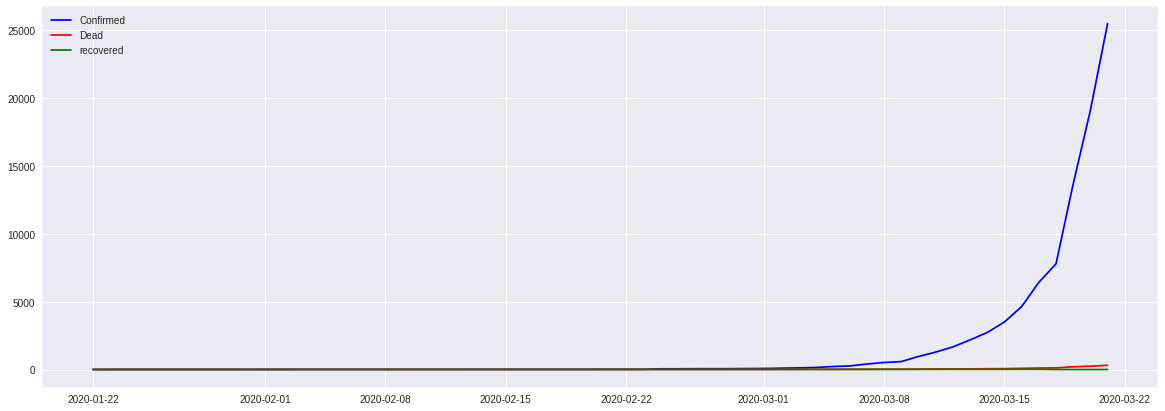

In [15]:
plot3(country)

## Officially confirmed cases per capita

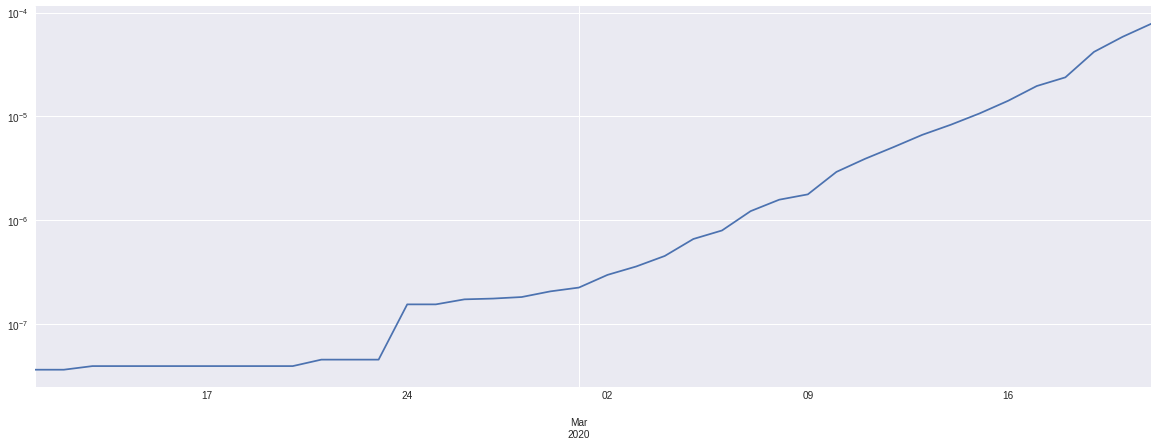

In [16]:
((con.loc[country][-40:])/pop[country]).plot(logy=True)

## Number of daily cases

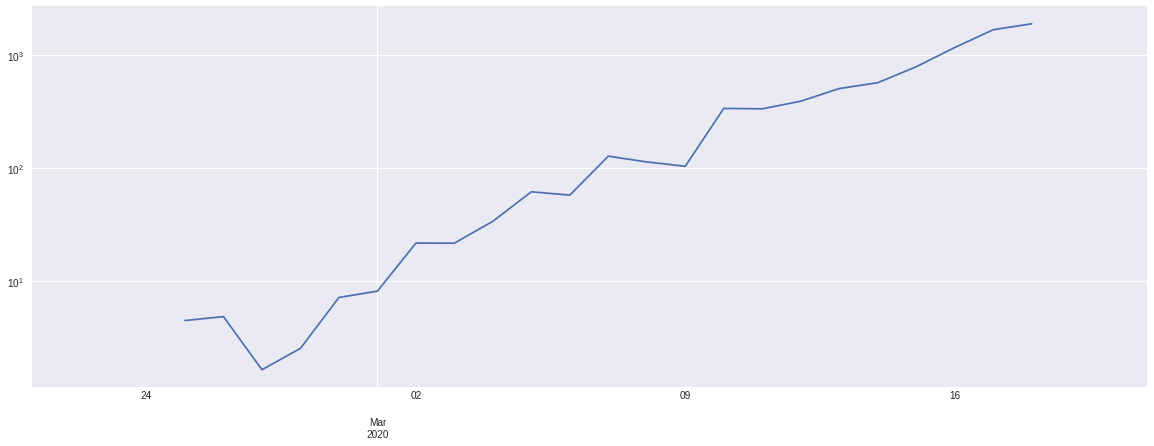

In [17]:
smoothDaily(con.loc[country][-30:]).plot(logy=True)

## Number of confirmed cases multiplication weekly

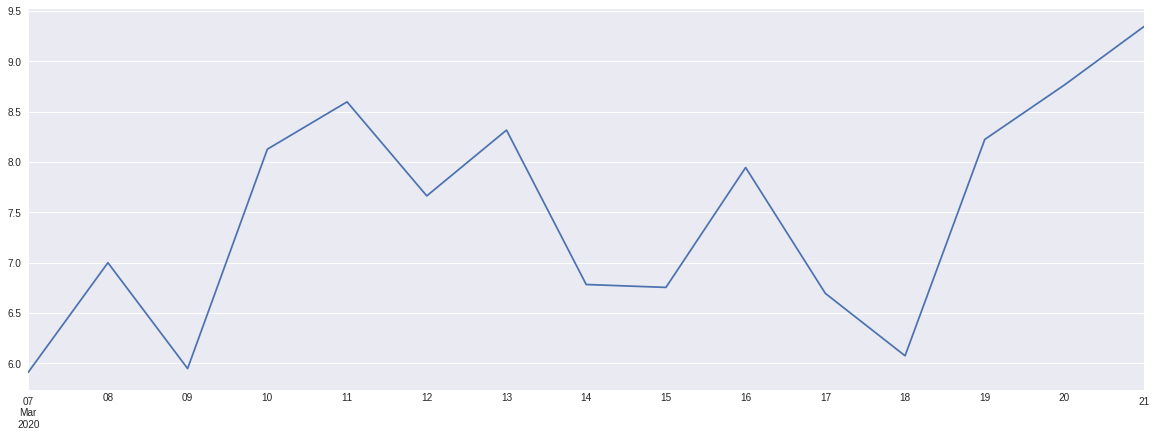

In [18]:
con_weekly = con.loc[country]
(con_weekly / con_weekly.shift(7))[-15:].plot()

## Number of deaths multication weekly

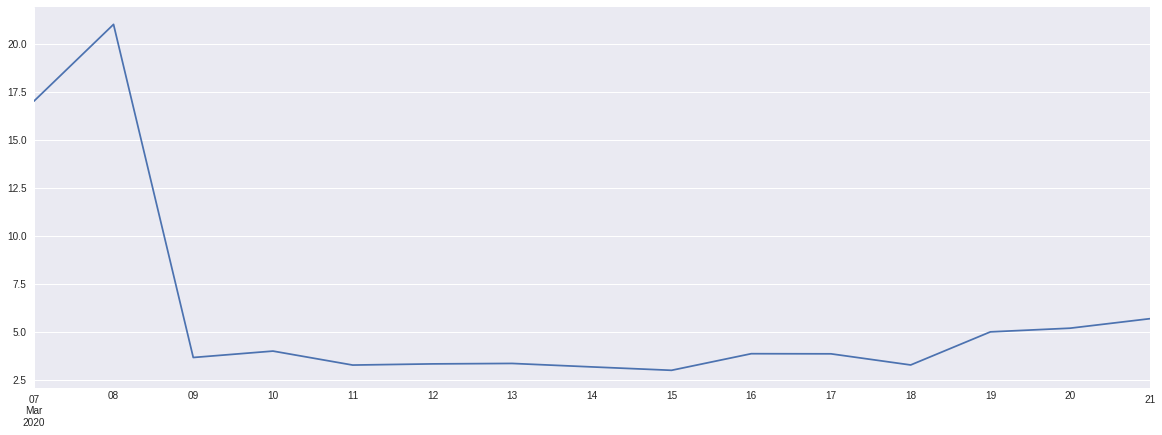

In [19]:
s = dea.loc[country]
(s / s.shift(7))[-15:].plot()

## Daily growth factor of confirmed

In [20]:

it_growth = last7Growth(con.loc[country])


Weekly growth: 7.686837080083628
Daily growth: 1.3382442386339022


## Estimates for current infection

T days ago confirmed_cases= 1663 backguess= 30700.0 ratio= 18.46061334936861
Last guess T days ago: 30700.0
Weekly growth: 7.686837080083628
Daily growth: 1.3382442386339022
Extrapolating with growht factor: 1.3382442386339022
Extrapolating to today from with growth factor: 422626.588971499
Reported confirmed today:  25489
Extrapolating from today confirmed by last ratio seen:  470542.57366205653


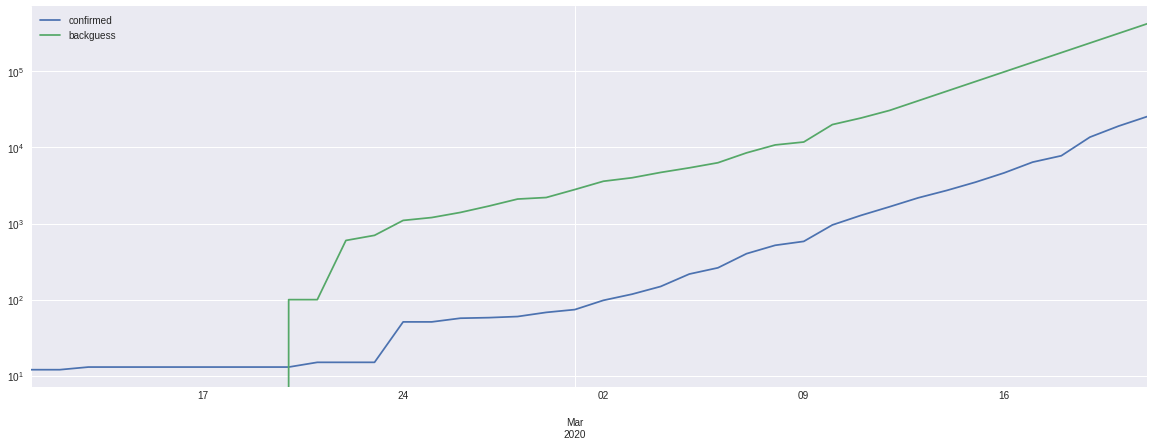

In [21]:
it_backguess = backGuess(country)
it_backguess[-40:].plot(logy=True)

## Percent of population

In [22]:
(it_backguess/pop[country]).iloc[-1]

confirmed    0.000078
backguess    0.001292
Name: 2020-03-21 00:00:00, dtype: float64

# Assuming exponential growth infected next week

In [23]:
it_backguess.backguess[-1] * it_growth**7

3248661.73513538

## Assuming exponential growth days until 50% is infected

In [24]:
math.log((pop[country]/2)/it_backguess.backguess[-1], it_growth)

20.45106441761852

## Assuming the constant number of new cases from here number of days until 50%

In [25]:
last_week_cases = (it_backguess.backguess[-1] - it_backguess.backguess[-8])
last_week_cases

367646.0313548283

In [26]:
(((pop[country]/2) - it_backguess.backguess[-1]) / last_week_cases)*7

3106.5958434755726